In [173]:
# Import libraries

import plistlib
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

In [174]:
# Load the library XML file

with open('Library.xml', 'rb') as file:
    plist = plistlib.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'Library.xml'

In [ ]:
# Extract tracks from plist data into a DataFrame

tracks = plist['Tracks']
df = pd.DataFrame(tracks).T  # Transpose so each track is a row

In [ ]:
def ms_to_s(ms):
    """Convert milliseconds to mm:ss format."""
    if pd.isna(ms):
        return None
    seconds = ms / 1000
    minutes = seconds // 60
    rem_seconds = seconds % 60
    
    return f"{int(minutes)}:{int(rem_seconds):02d}"

def ms_to_readable(ms):
    """Convert milliseconds to a readable format with days, hours, etc."""
    if pd.isna(ms) or ms <= 0:
        return "0s"
    
    seconds = int(ms / 1000)
    
    years, rem = divmod(seconds, 31536000)   # 365 days
    months, rem = divmod(rem, 2592000)       # 30 days
    days, rem = divmod(rem, 86400)
    hours, rem = divmod(rem, 3600)
    minutes, rem = divmod(rem, 60)
    secs = rem
    
    parts = []
    if years:
        parts.append(f"{years}y")
    if months:
        parts.append(f"{months}mo")
    if days:
        parts.append(f"{days}d")
    if hours:
        parts.append(f"{hours}h")
    if minutes:
        parts.append(f"{minutes}m")
    if secs:
        parts.append(f"{secs}s")

    return ' '.join(parts)

def bytes_to_megabytes(bytes):
    """Convert bytes to megabytes."""
    if pd.isna(bytes):
        return None
    return round(bytes / (1024 * 1024), 2)

In [ ]:
# Clean up DataFrame

# Set 'Track ID' as index
df.set_index('Track ID', inplace=True)

# Drop irrelevant columns
df = df.drop(columns=['Kind', 'Disc Number', 'Disc Count', 'Date Modified', 'Bit Rate', 'Sample Rate', 'Play Date', 'Artwork Count', 'Sort Album', 'Sort Artist', 'Sort Name', 'Persistent ID', 'Track Type', 'Apple Music', 'Normalization', 'Loved', 'Sort Album Artist', 'Compilation', 'Stop Time', 'Clean', 'Sort Composer', 'Comments', 'Matched', 'Volume Adjustment', 'Album Loved', 'Playlist Only', 'Album Rating', 'Album Rating Computed', 'Rating', 'Location', 'File Folder Count', 'Library Folder Count', 'Grouping', ])

# Fill NaN values
df[['Explicit', 'Favorited', 'Part Of Gapless Album']] = df[['Explicit', 'Favorited', 'Part Of Gapless Album']].fillna(False)
df[['Skip Count', 'Play Count']] = df[['Skip Count', 'Play Count']].fillna(0)

# Calculate total listening time
df['Listening Time (ms)'] = pd.to_numeric(df['Total Time']) * df['Play Count']
df['Listening Time'] = df['Listening Time (ms)'].apply(ms_to_readable)

# Convert 'Total Time' and 'Size' to a readable format
df['Total Time'] = pd.to_numeric(df['Total Time'])
df['Total Time'] = df['Total Time'].apply(ms_to_s)
df['Size'] = df['Size'].apply(bytes_to_megabytes)

# Rename columns for clarity
df.rename(columns={'Total Time': 'Time'}, inplace=True)
df.rename(columns={'Size': 'Size (MB)'}, inplace=True)
df.rename(columns={'Play Date UTC': 'Play Date'}, inplace=True)

# Convert date columns to datetime
df['Date Added'] = pd.to_datetime(df['Date Added'], errors='coerce')
df['Play Date'] = pd.to_datetime(df['Play Date'], errors='coerce').fillna(df['Date Added'])

/var/folders/rr/jdwhvnl573n1cmxbksk2ypgc0000gn/T/ipykernel_9434/4278636786.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Explicit', 'Favorited', 'Part Of Gapless Album']] = df[['Explicit', 'Favorited', 'Part Of Gapless Album']].fillna(False)
/var/folders/rr/jdwhvnl573n1cmxbksk2ypgc0000gn/T/ipykernel_9434/4278636786.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Skip Count', 'Play Count']] = df[['Skip Count', 'Play Count']].fillna(0)


In [ ]:
# Get play counts for each genre

genre_counts = df.groupby('Genre')['Play Count'].sum().sort_values(ascending=False)

In [ ]:
# Map genres to broader categories

genre_map = {
    'Rap': 'Hip-Hop/Rap',
    'Hip-Hop': 'Hip-Hop/Rap',
    'Gangsta Rap': 'Hip-Hop/Rap',
    'Alternative Rap': 'Hip-Hop/Rap',
    'Hip Hop/Rap': 'Hip-Hop/Rap',
    'Dirty South': 'Hip-Hop/Rap',
    'Hardcore Rap': 'Hip-Hop/Rap',
    'Hardcore': 'Hip-Hop/Rap',
    'Soul': 'R&B/Soul',
    'Electronic': 'EDM/Amapiano',
    'Electronica': 'EDM/Amapiano',
    'Dance': 'EDM/Amapiano',
    'Amapiano': 'EDM/Amapiano',
    'House': 'EDM/Amapiano',
    'Pop': 'Pop',
    'Alt. Rock': 'Alternative',
    'Indie Rock': 'Alternative',
    'Singer/Songwriter': 'Alternative',
    'Europe': 'Alternative',
    'Techno': 'Alternative',
    'Metal': 'Rock',
    'Hard Rock': 'Rock',
    'Worldwide': 'Afrobeats',
    'Afro-fusion': 'Afrobeats',
    'African': 'Afrobeats',
    'Alte': 'Afrobeats',
    'Afro-Beat': 'Afrobeats',
    'Afro-Pop': 'Afrobeats',
    'Reggae': 'Afrobeats',
    'Highlife': 'Afrobeats',
    'Urbano latino': 'Latin',
    'Indie Pop': 'Pop',
    'Soundtrack': 'Other',
    'New Wave': 'Other',
    'Holiday': 'Other',
}

In [ ]:
print("List of Available Styles : {}". format(plt.style.available))

List of Available Styles : ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
# Normalize genres and sort by play counts

# Create a new column for normalized genres
df['Normalized Genre'] = df['Genre'].map(genre_map).fillna(df['Genre'])
genres = df.groupby('Normalized Genre')['Play Count'].sum().sort_values(ascending=False)
df

,Name,Artist,Album Artist,Composer,Album,Genre,Size (MB),Time,Track Number,Track Count,...,Play Date,Skip Count,Skip Date,Release Date,Explicit,Favorited,Part Of Gapless Album,Listening Time (ms),Listening Time,Normalized Genre
Track ID,,,,,,,,,,,,,,,,,,,,,
2391,HUMBLE.,Kendrick Lamar,Kendrick Lamar,"Kendrick Lamar, A. Hogan, Michael L. Williams ...",DAMN.,Hip-Hop/Rap,6.09,2:57,8,14,...,2025-04-18 10:20:16,6,2024-06-10 22:51:25,2017-03-31 07:00:00,True,False,False,3540000,59m,Hip-Hop/Rap
2393,DNA.,Kendrick Lamar,Kendrick Lamar,K. Duckworth & M. Williams II,DAMN.,Hip-Hop/Rap,6.42,3:05,2,14,...,2025-02-14 18:32:07,12,2024-03-03 16:15:35,2017-04-14 12:00:00,True,False,False,3532993,58m 52s,Hip-Hop/Rap
2395,Mask Off,Future,Future,"Nayvadius Wilburn, Leland Wayne & Tommy Butler",FUTURE,Hip-Hop/Rap,6.97,3:24,7,20,...,2025-02-10 18:43:35,4,2023-05-26 07:06:50,2017-02-17 08:00:00,True,False,False,3069000,51m 9s,Hip-Hop/Rap
2397,Congratulations (feat. Quavo),Post Malone,Post Malone,"Austin Post, Louis Bell, Adam Feeney, Quavious...",Stoney (Deluxe),Hip-Hop/Rap,7.49,3:40,12,18,...,2025-05-20 22:40:30,9,2024-01-31 06:37:47,2016-11-04 07:00:00,True,True,False,7269405,2h 1m 9s,Hip-Hop/Rap
2399,Portland (feat. Quavo & Travis Scott),Drake,Drake,"Aubrey Drake Graham, Q. Marshall, J. Webster, ...",More Life,Hip-Hop/Rap,7.97,3:56,11,22,...,2024-07-04 04:48:18,6,2024-02-09 19:03:43,2017-03-18 12:00:00,True,False,False,6151990,1h 42m 31s,Hip-Hop/Rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21776,76rs,"G.T., Babyface Ray & Peezy","G.T., Babyface Ray & Peezy","Gary Alan Thomas, Phillip Glen Earl Peaks, Mar...",76rs - Single,Hip-Hop/Rap,5.61,2:42,1,1,...,2025-07-10 11:45:10,0,NaN,2025-06-06 12:00:00,True,False,True,162029,2m 42s,Hip-Hop/Rap
21779,Top of the World,Ace Hood,Ace Hood,"Ace Hood, Marco Rodriguez-Diaz & Ashaala Jenkins",DJ Khaled Presents Ace Hood: Gutta,Hip-Hop/Rap,7.48,3:30,15,16,...,2025-07-11 15:36:46,0,NaN,2008-11-18 12:00:00,True,False,False,210840,3m 30s,Hip-Hop/Rap
21782,Youth,Glass Animals,Glass Animals,Dave Bayley,How to Be a Human Being,Alternative,7.99,3:50,2,11,...,2025-07-11 15:19:32,0,NaN,2016-07-25 12:00:00,False,False,False,230693,3m 50s,Alternative


In [ ]:
df.columns

Index(['Name', 'Artist', 'Album Artist', 'Composer', 'Album', 'Genre',
       'Size (MB)', 'Time', 'Track Number', 'Track Count', 'Year',
       'Date Added', 'Play Count', 'Play Date', 'Skip Count', 'Skip Date',
       'Release Date', 'Explicit', 'Favorited', 'Part Of Gapless Album',
       'Listening Time (ms)', 'Listening Time', 'Normalized Genre'],
      dtype='object')

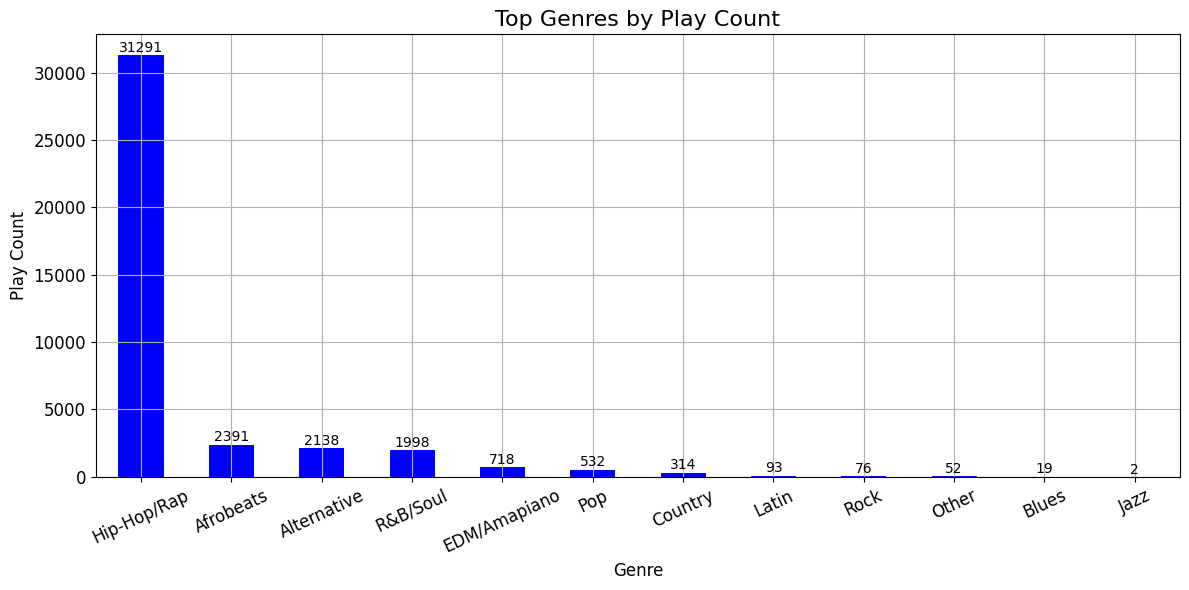

In [ ]:
# Analyze play counts by genre

genres.plot(kind='bar', figsize=(12,6), color='blue')
for i, value in enumerate(genres):
    plt.text(i, value + 10, str(value), ha='center', va='bottom', fontsize=10)
plt.ylabel('Play Count', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(rotation=25, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top Genres by Play Count', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

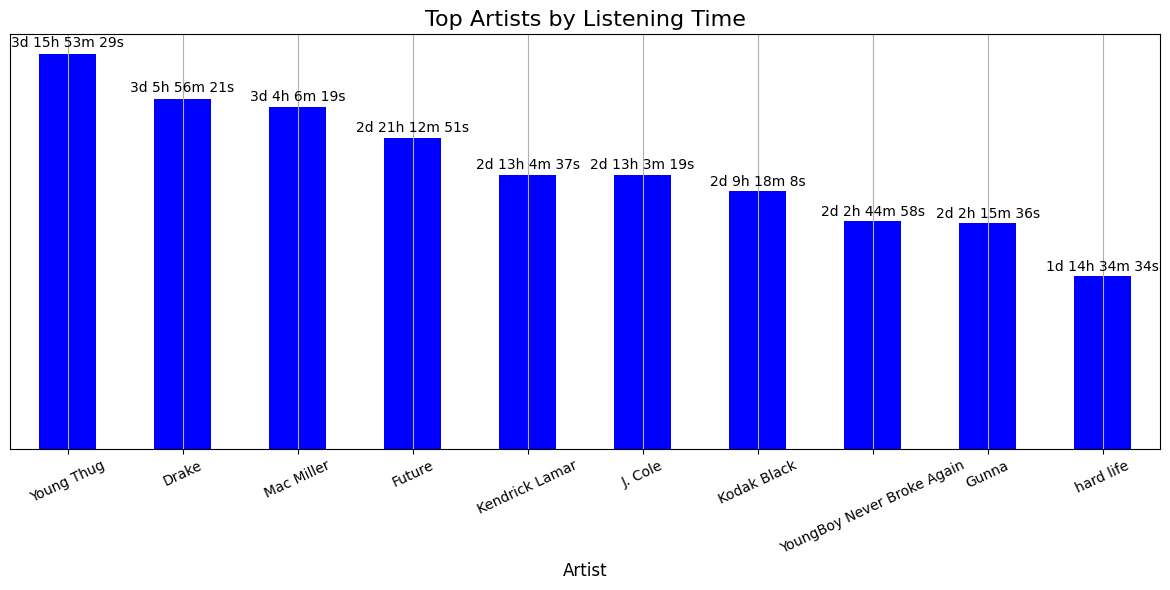

In [ ]:
# Analyze play time by artist

artists = df.groupby('Artist')['Listening Time (ms)'].sum().sort_values(ascending=False)
artists = artists.head(10)

artists.plot(kind='bar', figsize=(12,6), color='blue')
for i, value in enumerate(artists):
    label = ms_to_readable(value)
    plt.text(i, value + value * 0.01, label, ha='center', va='bottom', fontsize=10)
plt.xlabel('Artist', fontsize=12)
plt.xticks(rotation=25, fontsize=10)
plt.yticks([])
plt.title('Top Artists by Listening Time', fontsize=16)
plt.tight_layout()
plt.grid()
plt.show()

/var/folders/rr/jdwhvnl573n1cmxbksk2ypgc0000gn/T/ipykernel_9434/4070295813.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_genres).colors  # 'tab20' gives 20 distinct colors
/var/folders/rr/jdwhvnl573n1cmxbksk2ypgc0000gn/T/ipykernel_9434/4070295813.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_genres).colors


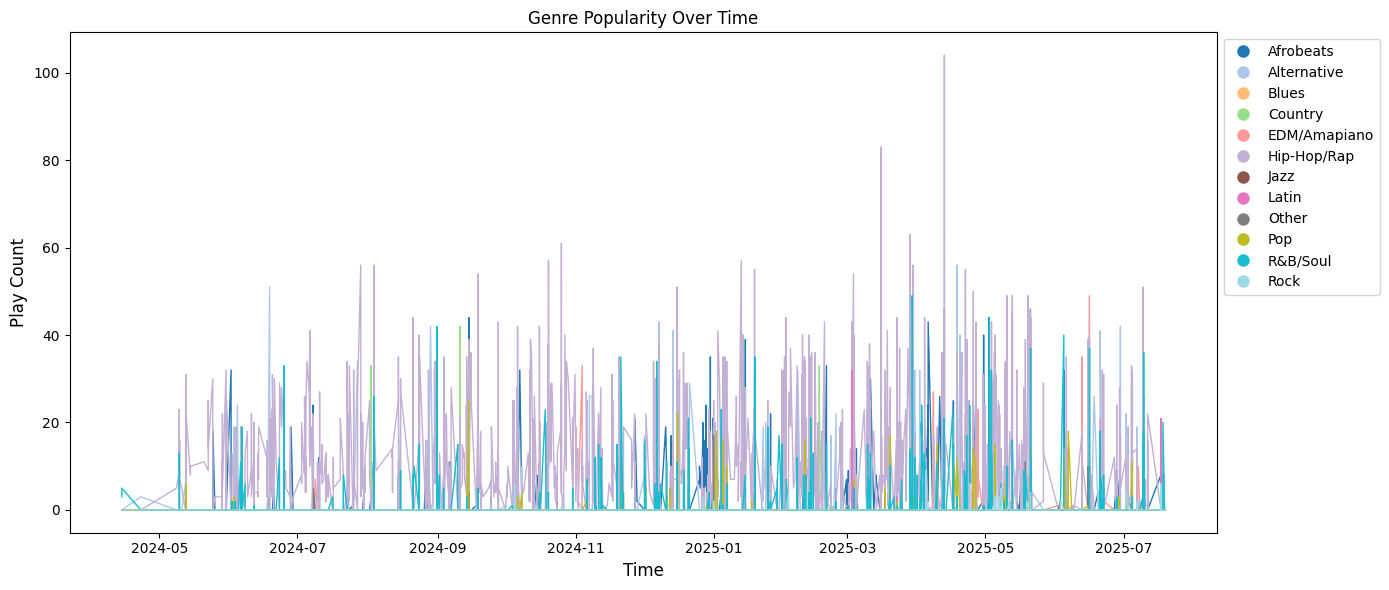

In [ ]:
# Analyze genre trends over time

# Convert 'Play Date' to datetime and group by date and genre
df['Play Date'] = pd.to_datetime(df['Play Date'], errors='coerce')
genre_trends = df.groupby(['Play Date', 'Normalized Genre'])['Play Count'].sum().unstack().fillna(0)

# Get a list of N unique colors (one for each genre)
num_genres = genre_trends.shape[1]
colors = cm.get_cmap('tab20', num_genres).colors  # 'tab20' gives 20 distinct colors

# Setup
fig, ax = plt.subplots(figsize=(14, 6))
num_genres = genre_trends.shape[1]
colors = cm.get_cmap('tab20', num_genres).colors

# Plot clean lines with no markers
for i, genre in enumerate(genre_trends.columns):
    ax.plot(genre_trends.index, genre_trends[genre], color=colors[i], linewidth=1)

# Build custom legend with circles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=genre,
           markerfacecolor=colors[i], markersize=10, linestyle='None')
    for i, genre in enumerate(genre_trends.columns)
]

# Add the legend
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Genre Popularity Over Time')
plt.ylabel('Play Count', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.tight_layout()
plt.savefig('charts/genre_trends.png', bbox_inches='tight')
plt.show()

In [ ]:
# Save the cleaned DataFrame to a CSV file

df.to_csv('docs/library.csv', index=False)